<a href="https://colab.research.google.com/github/choiblanc/K-VAN-Korea/blob/main/%EC%9E%90%EB%8F%99%20%EB%B0%B0%EC%B0%A8%20%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

/tmp/ipython-input-1-1313322559.py:294: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pay_df = df.applymap(lambda x: round(x/60*hourly_wage))


엑셀 파일 'Schedule_sheet.xlsx'로 저장 완료 (시트 1, 2, 3)


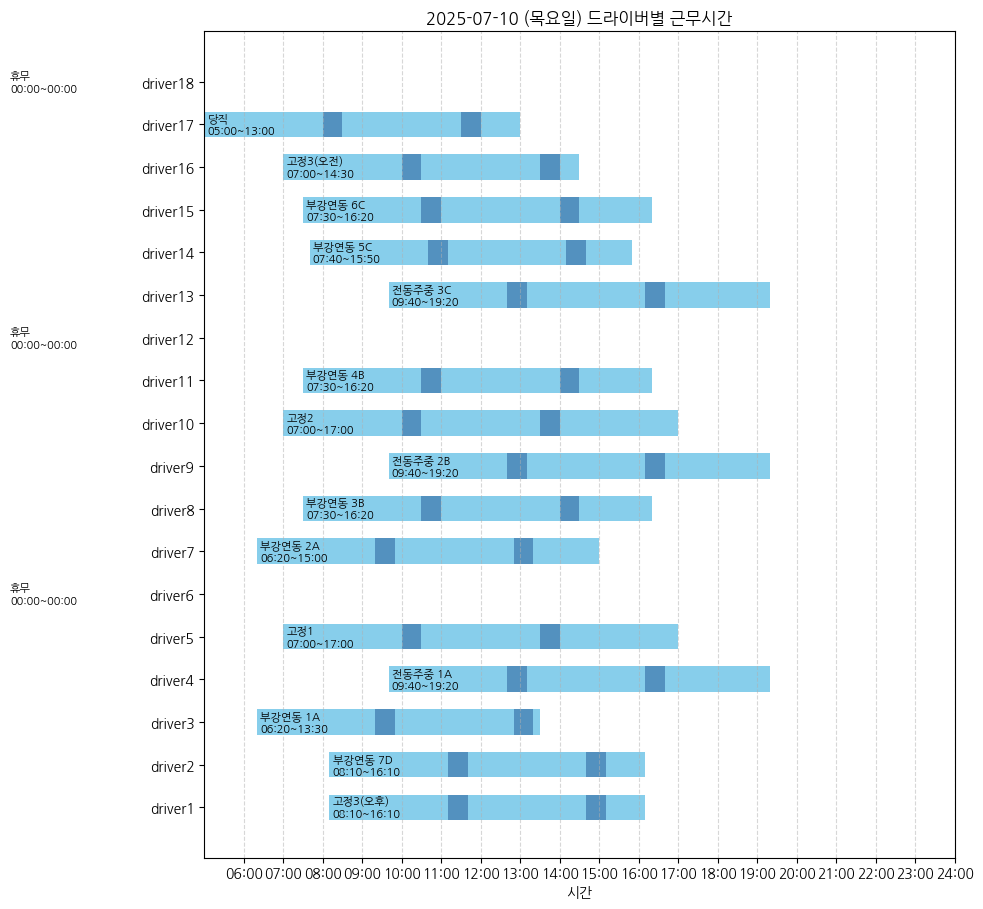

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from collections import defaultdict
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
import holidays

plt.rc('font', family='NanumGothic')  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# ====== 기본 설정 ======
kr_holidays = holidays.KR(years=2025)

# 1. 근무구역별 기본 근무시간(분)
base_minutes = {
    '부강연동 1A': 6*60+20,
    '부강연동 2A': 7*60+20,
    '부강연동 3B': 8*60+50,
    '부강연동 4B': 8*60+50,
    '부강연동 5C': 8*60+10,
    '부강연동 6C': 8*60+50,
    '부강연동 7D': 8*60,
    '전동주중 1A': 9*60+40,
    '전동주중 2B': 9*60+40,
    '전동주중 3C': 9*60+40,
    '부강연동 1A2A': 8*60,
    '부강연동 3B4B': 8*60,
    '부강연동 5C6C': 8*60,
    '전동 1A2B': 9*60,
    '전동 3C4D': 9*60,
    '고정1': 10*60,
    '고정2': 10*60,
    '고정3(오전)': 7*60+30,
    '고정3(오후)': 8*60+10,
    '당직': 7*60,
    '휴무': 0
}

# 2. 평일 추가시간(분)
weekday_add = {
    '부강연동 7D': 20,
    '부강연동 5C6C': 5,
    '고정1': 5,
    '고정3(오전)': 15,
    '고정3(오후)': 30,
    '당직': 30,
}

# 3. 주말/공휴일 추가시간(분)
weekend_add = {
    '부강연동 5C6C': 10,
    '고정1': 10,
    '고정3(오전)': 30,
    '고정3(오후)': 60,
    '당직': 60,
}

# 4. 주말/공휴일 1.5배 적용 구역
weekend_15x = [
    '부강연동 1A2A', '부강연동 3B4B', '부강연동 5C6C',
    '전동 1A2B', '전동 3C4D',
    '고정1', '고정2', '고정3(오전)', '고정3(오후)'
]

# ====== 근무 패턴 정의 ======
base_pattern = [
    '당직', '휴무', '고정3(오후)', '부강연동 7D', '부강연동 1A', '전동주중 1A', '고정1',
    '휴무', '부강연동 2A', '부강연동 3B', '전동주중 2B', '고정2', '부강연동 4B',
    '휴무', '전동주중 3C', '부강연동 5C', '부강연동 6C', '고정3(오전)'
]
saturday_pattern = [
    '휴무', '부강연동 1A2A', '휴무', '부강연동 5C6C', '고정3(오전)', '당직', '휴무', '고정3(오후)', '휴무', '전동 1A2B',
    '전동 3C4D', '고정1', '휴무', '부강연동 3B4B', '휴무', '휴무', '고정2', '휴무'
]
sunday_pattern = [
    '휴무', '휴무', '부강연동 1A2A', '휴무', '휴무', '고정3(오전)', '당직', '휴무', '고정3(오후)', '휴무', '전동 1A2B',
    '전동 3C4D', '고정1', '휴무', '부강연동 3B4B', '부강연동 5C6C', '휴무', '고정2'
]

patterns = {
    'weekday': base_pattern,
    'saturday': saturday_pattern,
    'sunday': sunday_pattern
}

drivers = [f"driver{i+1}" for i in range(18)]
holiday_dates = set(kr_holidays.keys())
fixed_roles = ['고정1', '고정2', '고정3(오전)', '고정3(오후)']



# ====== 도우미 함수 ======
def is_holiday(date):
    return date.date() in holiday_dates

def get_pattern_type(date):
    if date.weekday() == 5:
        return 'saturday'
    elif date.weekday() == 6:
        return 'sunday'
    elif is_holiday(date):
        # 공휴일이 평일일 경우, 토요일/일요일 패턴 중 더 가까운 쪽 패턴 적용
        weekday = date.weekday()
        to_saturday = (5 - weekday) % 7
        to_sunday = (6 - weekday) % 7
        return 'sunday' if to_saturday < to_sunday else 'saturday'
    else:
        return 'weekday'

def find_fixed_index(pattern, fixed_role_name):
    for i, duty in enumerate(pattern):
        if duty == fixed_role_name:
            return i
    return None

def shift_pattern(pattern, shift_amount):
    return pattern[-shift_amount:] + pattern[:-shift_amount]

def get_majority_shift(today_pattern, reference_pattern, fixed_roles):
    shifts = []
    for role in fixed_roles:
        ref_idx = find_fixed_index(reference_pattern, role)
        today_idx = find_fixed_index(today_pattern, role)
        if ref_idx is not None and today_idx is not None:
            shift = (ref_idx - today_idx) % len(today_pattern)
            shifts.append(shift)
    if not shifts:
        return 0
    return max(set(shifts), key=shifts.count)

# ====== 스케줄 생성 ======
def make_schedule_with_majority_shift(patterns, drivers, start_date, days=28):
    num_drivers = len(drivers)
    schedule = {driver: [] for driver in drivers}
    date_list = [start_date + timedelta(days=i) for i in range(days)]
    driver_indices = list(range(num_drivers))

    reference_pattern = None

    for day in range(days):
        today = date_list[day]
        pattern_type = get_pattern_type(today)
        pattern = patterns[pattern_type]
        pattern = pattern + ['휴무'] * (num_drivers - len(pattern))  # 부족한 부분은 휴무로 채움

        if reference_pattern is None:
            # 첫날 기준 패턴을 고정
            reference_pattern = pattern
            shifted_pattern = pattern
        else:
            shift_amount = get_majority_shift(pattern, reference_pattern, fixed_roles)
            shifted_pattern = shift_pattern(pattern, shift_amount)

        for i, driver in enumerate(drivers):
            duty_idx = driver_indices[i]
            schedule[driver].append(shifted_pattern[duty_idx])

        # 다음 날 대비 드라이버 인덱스 한 칸씩 시계 반대 방향으로 이동
        driver_indices = [(idx - 1) % num_drivers for idx in driver_indices]

    return schedule, date_list

def schedule_to_dataframe(schedule, drivers, date_list):
    columns = [d.strftime("%Y-%m-%d") for d in date_list]
    data = [schedule[driver] for driver in drivers]
    return pd.DataFrame(data, index=drivers, columns=columns)

# ====== 색상 매핑 및 엑셀 저장 ======
color_map = {
    "당직": "FFA500",
    "휴무": "FFFFFF",
    "고정3(오후)": "FF0000",
    "고정3(오전)": "FF0000",
    "고정1": "FF0000",
    "고정2": "FF0000",
    "부강연동 1A": "FFFF00",
    "부강연동 2A": "FFFF00",
    "부강연동 3B": "FFFF00",
    "부강연동 4B": "FFFF00",
    "부강연동 5C": "FFFF00",
    "부강연동 6C": "FFFF00",
    "부강연동 7D": "FFFF00",
    "부강연동 1A2A": "FFDAB9",
    "부강연동 3B4B": "FFDAB9",
    "부강연동 5C6C": "FFDAB9",
    "전동주중 1A": "00B050",
    "전동주중 2B": "00B050",
    "전동주중 3C": "00B050",
    "전동 1A2B": "87CEEB",
    "전동 3C4D": "87CEEB",
}

def apply_color_to_excel(filename, sheet_name, drivers, date_list, color_map):
    wb = load_workbook(filename)
    ws = wb[sheet_name]
    for row_idx, driver in enumerate(drivers, start=2):
        for col_idx, _ in enumerate(date_list, start=2):
            cell = ws.cell(row=row_idx, column=col_idx)
            duty = str(cell.value)
            color = color_map.get(duty)
            if color:
                cell.fill = PatternFill(start_color=color, end_color=color, fill_type="solid")
    wb.save(filename)

# ====== 운전자별 구역별 평일/주말 근무 집계 ======
def count_work_by_driver_and_area(schedule, date_list):
    def is_weekend(date):
        return date.weekday() in (5, 6) or is_holiday(date)

    driver_area_stats = defaultdict(lambda: defaultdict(lambda: {'평일근무':0, '주말근무':0}))

    for driver, duties in schedule.items():
        for duty, date in zip(duties, date_list):
            duty_str = str(duty)
            if '휴무' in duty_str:
                continue  # 휴무면 근무 아님

            # 휴무 아닌 모든 것은 근무로 간주 (고정, 당직 포함)
            area = duty_str.strip()
            weekend = is_weekend(date)
            if weekend:
                driver_area_stats[driver][area]['주말근무'] += 1
            else:
                driver_area_stats[driver][area]['평일근무'] += 1

    return driver_area_stats

def create_pivot_work_df(stats):
    rows = []
    for driver, area_dict in stats.items():
        for area, counts in area_dict.items():
            total = counts['평일근무'] + counts['주말근무']
            rows.append({
                '운전자': driver,
                '구역': area,
                '근무횟수': total,
                '평일근무': counts['평일근무'],
                '주말근무': counts['주말근무']
            })
    df = pd.DataFrame(rows)
    # 총 근무, 평일, 주말 각각 피벗
    pivot_total = pd.pivot_table(df, values='근무횟수', index='구역', columns='운전자', fill_value=0)
    pivot_weekday = pd.pivot_table(df, values='평일근무', index='구역', columns='운전자', fill_value=0)
    pivot_weekend = pd.pivot_table(df, values='주말근무', index='구역', columns='운전자', fill_value=0)
    # MultiIndex로 합치기
    pivot_df = pd.concat(
        {'총근무': pivot_total, '평일근무': pivot_weekday, '주말근무': pivot_weekend},
        axis=1
    )
    # 운전자별 토탈(합계) 계산
    driver_totals = pd.DataFrame({
        '총근무': pivot_total.sum(axis=0),
        '평일근무': pivot_weekday.sum(axis=0),
        '주말근무': pivot_weekend.sum(axis=0)
    }).T
    # 구역별 피벗 아래에 합계 행 추가
    pivot_df = pd.concat([pivot_df, driver_totals], axis=0)
    return pivot_df

# ====== 근무시간 계산 함수 ======
def is_weekend_or_holiday(date):
    return date.weekday() >= 5 or date.date() in kr_holidays

def get_work_minutes(area, date):
    base = base_minutes.get(area, 0)
    if base == 0:
        return 0
    weekend = is_weekend_or_holiday(date)
    if weekend and area in weekend_15x:
        add = weekend_add.get(area, 0)
        return int(base * 1.5 + add)
    elif weekend:
        add = weekend_add.get(area, 0)
        return base + add
    else:
        add = weekday_add.get(area, 0)
        return base + add

# ====== 월별/연별 급여 계산 함수 ======
hourly_wage = 12036

def calc_monthly_and_yearly_pay(schedule, date_list):
    pay_data = defaultdict(lambda: defaultdict(int))  # driver -> month -> 분
    for driver, duties in schedule.items():
        for duty, date in zip(duties, date_list):
            minutes = get_work_minutes(duty, date)
            month = date.strftime('%Y-%m')
            pay_data[driver][month] += minutes
    # DataFrame 변환
    df = pd.DataFrame(pay_data).T  # index=driver, columns=month
    df = df.fillna(0).astype(int)
    # 월급 계산
    pay_df = df.applymap(lambda x: round(x/60*hourly_wage))
    # 1년 총합 열 추가
    pay_df['연간합계'] = pay_df.sum(axis=1)
    # 전체 합계 행 추가
    total_row = pay_df.sum(axis=0)
    total_row.name = '전체합계'
    pay_df = pd.concat([pay_df, total_row.to_frame().T])
    # 월별 순서 정렬
    month_cols = sorted([c for c in pay_df.columns if c not in ['연간합계', '전체합계']])
    pay_df = pay_df[month_cols + ['연간합계']]
    return pay_df

# ====== 시각화 함수 ======
def time_to_minutes(t_str):
    h, m = map(int, t_str.split(":"))
    return h * 60 + m

# 평일 구역별 근무시간 데이터 예시 (start: 시작시간, end: 종료시간, duration: 분 단위 근무 시간)
data = [
    {"area": "부강연동 1A", "start": "06:20", "end": "13:30"},
    {"area": "부강연동 2A", "start": "06:20", "end": "15:00"},
    {"area": "부강연동 3B", "start": "07:30", "end": "16:20"},
    {"area": "부강연동 4B", "start": "07:30", "end": "16:20"},
    {"area": "부강연동 5C", "start": "07:40", "end": "15:50"},
    {"area": "부강연동 6C", "start": "07:30", "end": "16:20"},
    {"area": "부강연동 7D", "start": "08:10", "end": "16:10"},
    {"area": "전동주중 1A", "start": "09:40", "end": "19:20"},
    {"area": "전동주중 2B", "start": "09:40", "end": "19:20"},
    {"area": "전동주중 3C", "start": "09:40", "end": "19:20"},
    {"area": "고정1", "start": "07:00", "end": "17:00"},
    {"area": "고정2", "start": "07:00", "end": "17:00"},
    {"area": "고정3(오전)", "start": "07:00", "end": "14:30"},
    {"area": "고정3(오후)", "start": "08:10", "end": "16:10"},
    {"area": "당직", "start": "05:00", "end": "13:00"},
    {"area": "휴무", "start": "00:00", "end": "00:00"},
]

# data에 duration과 start_min 추가 (초기화용)
for d in data:
    d['start_min'] = time_to_minutes(d['start'])
    d['end_min'] = time_to_minutes(d['end'])
    d['duration'] = d['end_min'] - d['start_min']

# 주말 근무시간 정보 (key: 구역명, value: (시작, 지속시간, 시작시각, 종료시각))
weekend_time_info = {
    "부강연동 1A2A": (time_to_minutes("07:00"), 8*60, "07:00", "15:00"),
    "부강연동 3B4B": (time_to_minutes("07:40"), 7*60+50, "07:40", "15:30"),
    "부강연동 5C6C": (time_to_minutes("07:00"), 8*60, "07:00", "15:00"),
    "전동 1A2B": (time_to_minutes("09:40"), 8*60+10, "09:40", "18:00"),
    "전동 3C4D": (time_to_minutes("09:40"), 8*60+10, "09:40", "18:00"),
    "고정1": (time_to_minutes("07:00"), 9*60, "07:00", "16:00"),
    "고정2": (time_to_minutes("07:00"), 9*60, "07:00", "16:00"),
    "고정3(오전)": (time_to_minutes("07:00"), 7*60+30, "07:00", "14:30"),
    "고정3(오후)": (time_to_minutes("08:10"), 8*60+10, "08:10", "16:20"),
}

# 주말 이중차량 구역 예시 (key: 구역명, value: [(1부 시작, 1부 종료), (2부 시작, 2부 종료)])
dual_vehicle_weekend_areas = {
    "부강연동 5C6C": [("07:00", "11:00"), ("11:30", "15:00")],
    "전동 1A2B": [("09:40", "13:40"), ("14:10", "18:00")],
}

# 고정 역할 리스트 (주말/평일 관계없이 근무 패턴 확인용)
fixed_roles = ['고정1', '고정2', '고정3(오전)', '고정3(오후)']

# 주신 함수 그대로 조금만 변수명 정리해서 다시 올립니다
def visualize_schedule_for_date(schedule, date_list, data, drivers, target_date_str):

    target_date = datetime.strptime(target_date_str, "%Y-%m-%d")
    weekday_name = target_date.strftime("%A")

    kor_weekdays = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    weekday_name_kr = kor_weekdays[target_date.weekday()]

    try:
        date_idx = date_list.index(target_date)
    except ValueError:
        print(f"{target_date_str} 는 스케줄 날짜 범위에 없습니다.")
        return

    duties_on_date = [schedule[driver][date_idx] for driver in drivers]
    pattern_type = get_pattern_type(target_date)

    # 시간 정보 선택
    if pattern_type == 'weekday':
        time_info = {d['area']: (d['start_min'], d['duration'], d['start'], d['end']) for d in data}
    else:
        time_info = weekend_time_info

    def get_time_for_duty(duty_name):
        if duty_name in fixed_roles:
            d = next((d for d in data if d['area'] == duty_name), None)
            if d:
                return d['start_min'], d['duration'], d['start'], d['end']
            else:
                return 0, 0, '00:00', '00:00'
        for key in time_info.keys():
            if duty_name.startswith(key):
                return time_info[key]
        return (0, 0, '00:00', '00:00')

    fig, ax = plt.subplots(figsize=(10, len(drivers)*0.4 + 2))
    y_pos = range(len(drivers))

    for i, duty in enumerate(duties_on_date):
        # 주말 이중차량 구역일 경우
        if duty in dual_vehicle_weekend_areas and pattern_type in ['saturday', 'sunday']:
            shifts = dual_vehicle_weekend_areas[duty]
            colors = ['lightblue', 'deepskyblue']  # 1부 / 2부 색상
            for shift_idx, (start_str, end_str) in enumerate(shifts):
                start_min = time_to_minutes(start_str)
                end_min = time_to_minutes(end_str)
                duration = end_min - start_min
                ax.barh(i, duration, left=start_min, height=0.6, color=colors[shift_idx])
                ax.text(start_min + 5, i, f"{duty} ({shift_idx+1}부)", va='center', fontsize=8)
        else:
            start_min, duration, start_str, end_str = get_time_for_duty(duty)
            ax.barh(i, duration, left=start_min, height=0.6, color="skyblue")
            ax.text(start_min + 5, i, f"{duty}\n{start_str}~{end_str}", va='center', fontsize=8)

        # 휴식시간 표시
        rest_start = start_min + 180
        while rest_start + 30 <= start_min + duration:
            ax.barh(i, 30, left=rest_start, height=0.6, color="#4682B4", alpha=0.8)
            rest_start += 210  # 다음 휴식 구간 이동

    ax.set_yticks(y_pos)
    ax.set_yticklabels(drivers)
    ax.set_xlim(300, 1440)
    ax.set_xticks(range(360, 1441, 60))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(6, 25)])
    ax.set_xlabel("시간")

    weekday_name_kr = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일'][target_date.weekday()]
    ax.set_title(f"{target_date_str} ({weekday_name_kr}) 드라이버별 근무시간")

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()




# ====== 메인 실행부 ======
if __name__ == "__main__":
    start_date = datetime(2025, 1, 1)
    days = 365  # 1년

    # 스케줄 생성
    schedule, date_list = make_schedule_with_majority_shift(patterns, drivers, start_date, days)

    # 스케줄 DataFrame 변환
    all_ = schedule_to_dataframe(schedule, drivers, date_list)

    # 운전자별 구역별 근무 횟수 집계
    stats = count_work_by_driver_and_area(schedule, date_list)
    pivot_df = create_pivot_work_df(stats)

    # 월별 연간 급여 계산
    pay_df = calc_monthly_and_yearly_pay(schedule, date_list)

    # 엑셀 저장
    excel_filename = "Schedule_sheet.xlsx"
    with pd.ExcelWriter(excel_filename, engine="openpyxl") as writer:
        all_.to_excel(writer, sheet_name="1_근무스케줄", index=True)
        pivot_df.to_excel(writer, sheet_name="2_구역별근무요약", index=True)
        pay_df.to_excel(writer, sheet_name="3_월별연간급여", index=True)

    # 엑셀 색상 적용
    apply_color_to_excel(excel_filename, "1_근무스케줄", drivers, date_list, color_map)

    print(f"엑셀 파일 '{excel_filename}'로 저장 완료 (시트 1, 2, 3)")

    # 시각화 예시: 원하는 날짜 입력
    visualize_schedule_for_date(schedule, date_list, data, drivers, "2025-07-10")

